# Емоджи генератор
#### Проект по "Подходи за обработка на естествен език" 2024/25

**Изработили:**
- Ана Петрова (ФН: 8MI3400459)
- Антонина Ускова (ФН: 4M13400583)
- Иван-Асен Чакъров (ФН: 6MI3400634)

## Описание на проблема

Проблемът, който решаваме в този проект е следният:
По даден входящ текст на английски език, да се имплементира алгоритъм, който променя някои от думите
в Unicode емоджита. Всяка дума може или да не бъде заместена или да бъде заместена с точно $1$ емоджи. Целта е максимално много да се запази смисъла на оригиналния текст
и да има максимално много емоджита.

Погледнато грубо, задачата е подобна на машинен превод от английски към "език на емоджитата".
Основната разлика, която опростява и решенията на този проблем е, че този "език на емоджитата"
има абсолютно същата граматика като входящия език, тъй като е просто замяна на някои думи с други.

Както се подразбира от горе, не е задължително всички думи да бъдат заменени с емоджита.
Всеки алгоритъм трябва да решава кои думи и с какво е най-добре да бъдат заменени.
- Пример за частична замяна:
    ```
    Вход: "Chicken lays eggs"
    Изход: "🐔 lays 🥚"
    ```
- Пример за "перфектна" замяна:
    ```
    Вход: "star boy"
    Изход: "⭐ 👦"
    ```
- Пример за "лоша" замяна:
    ```
    Вход: "I want a castle for Christmas"
    Изход: "I want a 🍕 for 🐔"
    ```

Ще представим няколко подхода за решаване на задачата и след това ще ги оценим като използваме
наш метод, направен специално за оценяване на модели, решаващи тази задача.

In [ ]:
###############################################################
# Boilerplate code for setting up the rest of the notebook
###############################################################

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/emoji_generator/

import sys
sys.path.append('/content/drive/MyDrive/emoji_generator/')

import numpy as np
import pandas as pd
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
from importlib import reload
from nltk.corpus import stopwords
import nltk
import stem_model as sm
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
import kagglehub
import matplotlib
import os
import random
import re
from collections.abc import Callable
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

reload(sm)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/emoji_generator


<module 'stem_model' from '/content/drive/MyDrive/emoji_generator/stem_model.py'>

In [ ]:
nltk.download('punkt_tab')
nltk.download('brown')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words('english'))

emojis_dataset = pd.read_csv("./emojis.csv")
emoji_to_name = {}
for _, emoji in emojis_dataset.iterrows():
  emoji_to_name[emoji.Representation] = emoji.Name

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

stop_words = set(stopwords.words('english'))

###############################################################
# End: Boilerplate code for setting up the rest of the notebook
###############################################################

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## Подход #1: Предварителна обработка на текста и директно заместване

Основното нещо от което ще се възползваме в това решение на проблема,
както и в другите е, че всяко емоджи си има "име", което е кратко
изречение на английски език.

Първият модел, който ще разгледаме е сравнително по-прост от следващите. Първо всяка дума се обработва предварително със
следната процедура:
```python
def pre_process(self, text: str) -> list[str]:
  clean = re.sub(r'[^\w\s]', '', text)
  tokens = word_tokenize(clean)
  stemmed_tokens = [stem(t) for t in tokens]
  tokens = [t for t in stemmed_sent if t not in stop_words]
  return tokens
```

След това за всяко емоджи в нашия корпус от емоджита, прилагаме
`pre_process` към неговото име. След това, при вход някакво изречение `t` правим следното:
1. Викаме `pre_process(t)`.
1. За всеки токен `x` търсим в корпуса от емоджита, най-късото емоджи,
   което съдържа в своето "обработено име" същия токен `x`. Ако имаме
   съответсвие, заместваме емоджито в изречението, а пък ако нямаме
   оставяме оригиналната дума.

Ето няколко примерни резултата:

In [ ]:
stem_model = sm.StemModel(emojis_dataset, stop_words)

/content/drive/MyDrive/emoji_generator/stem_model.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.emojis_dataset["Stemmed"] = [self.pre_process(name) for name in emojis_dataset.Name]


In [ ]:
print(stem_model("Star boy"))
print(stem_model("I love you "))
print(stem_model("The pizza is great"))
print(stem_model("Chicken lays eggs "))
print(stem_model("I have scored hundred in maths "))
print(stem_model("She is the queen of hearts "))
print(stem_model("Messi is the king of soccer "))
print(stem_model("Lets build a rocket "))

⭐ 👦 
I 💌 you 
The 🍕 is great 
🐔 lays 🥚 
I have 🎼 💯 in maths 
She is the queen of ♥️ 
Messi is the king of ⚽ 
Lets 🏛️ a 🚀 


### Подход #2: Wordnet + POS-tagging

В този подход са обединени търсене на подобие, чрез намиране на близост на думи, и POS-tagging. Обединението ни помага за по-добри резултати, защото, след като определим всяка една дума от даденото ни изречение каква част на речта е, можем по-точно да намерим нейните съноними, използвайки Wordnet, които са същата част на речта и съответно да определим по-точно емоджито.

В началото се бях насочила към подход само с Wordnet, но при него получавах не толкова добри резултати, защото се взимаха всички синоними за една дума, без да се отчитта каква част на речта е тя. Това водеше до "лоши" замени. Затова добавих POS-tagging, което подобри резултатите.

За да може една дума да бъде заменена с емоджи е нужно:
>      similarity(w1, w2) >= threshold

In [ ]:
stop_words = set(stopwords.words('english'))

emojis_dataset_ani = pd.read_csv("./emojis.csv")
emojis_dataset_ani = emojis_dataset_ani[["Representation", "Name"]]
emojis_dataset_ani

,Representation,Name
0,🎃,jack-o-lantern
1,🎄,Christmas tree
2,🎆,fireworks
3,🎇,sparkler
4,🧨,firecracker
...,...,...
4585,☄️,comet
4586,☄,comet
4587,🔥,fire
4588,💧,droplet


In [ ]:
def pre_process(sentence) -> list[str]:
  lemmatizer = WordNetLemmatizer()
  sentence = sentence.lower()
  clean_sent = re.sub(r'[^\w\s]', '', sentence)
  tokens = word_tokenize(clean_sent)
  tokens = [t for t in tokens if t not in stop_words]
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  return tokens

Преди да приложим подхода всяка една дума от изреченията, които обработваме, както и името на емоджитата, ги обработваме:
- разделяме изречението на отделни думи
- за всяка една дума проверяваме дали не е част от корпуса със стоп-думи
- за всяка една дума и намираме основната форма, като използваме *WordNetLemmatizer()*

След като прилагам *pre_process* за всяко едно емоджи от корпуса:

In [ ]:
emojis_dataset_ani = emojis_dataset_ani[["Representation", "Name"]]
emojis_dataset_ani["cleaned_text"] = emojis_dataset_ani["Name"].apply(pre_process)
emojis_dataset_ani

,Representation,Name,cleaned_text
0,🎃,jack-o-lantern,[jackolantern]
1,🎄,Christmas tree,"[christmas, tree]"
2,🎆,fireworks,[firework]
3,🎇,sparkler,[sparkler]
4,🧨,firecracker,[firecracker]
...,...,...,...
4585,☄️,comet,[comet]
4586,☄,comet,[comet]
4587,🔥,fire,[fire]
4588,💧,droplet,[droplet]


In [ ]:
def find_synonym_words(word, pos_tagged):
    keep = []
    returned = []
    synsets = wordnet.synsets(word, pos=pos_tagged)
    for synset in synsets:
        synonym = synset.name().split(".")[0]
        if synonym not in keep:
            keep.append(synonym)
            returned.append(synset)

    return returned

Намирането на синоними за дадена дума, в зависимост каква е частта от речта на тази дума, е добър начин да генерираме првилното емоджи.
Функцията *find_synonym_words(word, pos_tagged)* взима входна дума, извлича нейните synset(сет от синоними) от WordNet и извлича уникални синоними въз основа на имената на synset. Връща списък с различни синонимни думи.

In [ ]:
def get_hypernyms(word, pos_tagged):
    hypernyms = set()
    for syn in wordnet.synsets(word, pos=pos_tagged):
        for hypernym in syn.hypernyms():
                hypernyms.add(hypernym)
    return hypernyms

WordNet ни предоставя възможност за всяка една дума освен да намерим синонимите, да намерим и нейните така наречени hypernym-и.
> Hypernym e дума с широко значение, съставляваща категория, в която попадат думите с по-специфични значения; Например color е hypernym на red.

Това ще ни помогне в случаите, в които не сме намерили синоним, който да ни дава подобие, което да удовлетворява прага на подобие, които сме определили.

Добър пример за това е думата *coffee*.

Нейните синоними са:

In [ ]:
coffee = find_synonym_words("coffee", wordnet.NOUN)
coffee

[Synset('coffee.n.01'), Synset('coffee_bean.n.01'), Synset('chocolate.n.03')]

В корпуса ни с емоджита няма такова, което да отговаря на тази дума. За сметка на това има емоджи, подходящо на заманя, което е
>Food-Drink,drink,2615,fully-qualified,☕,hot beverage,E0.6

Но сред синонимите на *coffee* не намираме *hot beverage*.

Сега нега вземем *hypernyms* на *coffee*:

In [ ]:
coffee_hypernyms = get_hypernyms("coffee")
coffee_hypernyms

{Synset('beverage.n.01'),
 Synset('brown.n.01'),
 Synset('seed.n.01'),
 Synset('tree.n.01')}

In [ ]:
def get_emoji_exact_synset(emoji_name, emoji_synsets):
    for synset in emoji_synsets:
        if emoji_name in synset.lemma_names():
            return synset
    return None

Нас ни интересува за всяка дума от изреченията да вземем нейните синоними или хиперсиноними. Това не важи за имената на емоджитата. Тях искаме да запазим. Затова за всяко име на емоджи искаме да вземем тези синоними, чиито имена съвпадат напълно.

In [ ]:
coffee_synsets = wordnet.synsets("coffee", pos=wordnet.NOUN)
print(coffee_synsets)
coffee = get_emoji_exact_synset("coffee", coffee_synsets)
coffee

[Synset('coffee.n.01'), Synset('coffee.n.02'), Synset('coffee_bean.n.01'), Synset('chocolate.n.03')]


Synset('coffee.n.01')

In [ ]:
def penn_to_wn(tag):
    """Convert Penn Treebank POS tags to WordNet POS tags."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def get_best_matching_emoji(word_synset, emoji_dataset, threshold):
    best_emoji = None
    best_similarity = 0

    if not word_synset:
        return None, 0

    emoji_dict = {row["Representation"]: row["cleaned_text"] for _, row in emoji_dataset.iterrows()}

    for emoji, emoji_names in emoji_dict.items():
        for emoji_name in emoji_names:
            emoji_name_synsets = wordnet.synsets(emoji_name)

            if not emoji_name_synsets:
                continue

            emoji_synset = get_emoji_exact_synset(emoji_name, emoji_name_synsets)

            if not emoji_synset:
                continue

            similarity = word_synset.path_similarity(emoji_synset)
            if similarity and similarity > best_similarity:
                best_similarity = similarity
                best_emoji = emoji

    return (best_emoji, best_similarity) if best_similarity >= threshold else (None, best_similarity)

За да вземем най-подходящото емоджи, за една дума от изречението проверяваме всички емоджита в нашия корпус и изчисляваме:
>similarity = word_synset.path_similarity(emoji_synset)

Ако то е по-голямо от текущото най-добро подобие, взимаме него. Накрая проверяваме дали удовлетворя нашия праг на подобие(threshold).

За всяка една дума първо търсим всички синоними, ако при тях няма подходящо емоджи, удовлетворяващо условията, проверява за всички хиперсиноними.

In [ ]:
def replace_with_emoji_wordnet(sentence, emoji_dataset, threshold = 0.6):
    tokens = word_tokenize(sentence)
    tagged_words = pos_tag(tokens)
    modified_tokens = []
    similarities = {}

    for token, tag in tagged_words:
        pre_processed_token = pre_process(token)
        wn_tag = penn_to_wn(tag)

        if not pre_processed_token:
            modified_tokens.append(token)
            continue

        best_emoji = None
        best_similarity = 0

        pre_processed_token = pre_processed_token[0]
        synonyms = find_synonym_words(pre_processed_token, wn_tag)
        for synonum_synset in synonyms:
            best_emoji, best_similarity = get_best_matching_emoji(synonum_synset, emoji_dataset, threshold)
            if best_emoji:
                break

        if not best_emoji:
            hypernyms = get_hypernyms(pre_processed_token, wn_tag)
            for hypernym in hypernyms:
                best_emoji, best_similarity = get_best_matching_emoji(hypernym, emoji_dataset, threshold)
                if best_emoji:
                    break

        if best_emoji:
            modified_tokens.append(best_emoji)
        else:
            modified_tokens.append(token)

        similarities[token] = best_similarity

    modified_sentence = " ".join(modified_tokens)

    return modified_sentence, similarities

def wordnet_model(sentence):
    modified_sentence, _ = replace_with_emoji_wordnet(sentence, emojis_dataset_ani)
    return modified_sentence

In [ ]:
test_sentences = [
    "I want pizza and a movie night.",
    "This is such a sad day.",
    "Happy birthday to you!",
    "I need a vacation by the beach.",
    "star boy",
    "i love you ",
    "the pizza is great",
    "chicken lays eggs ",
    "i have scored hundred in maths ",
    "She is the queen of hearts ",
    "messi is the king of soccer ",
    "lets build a rocket "
]

for sent in test_sentences:
    modified_sentence, similarity = replace_with_emoji_wordnet(sent, emojis_dataset_ani)
    print(f"Input: {sent}")
    print(f"Modified Sentence: {modified_sentence}")
    print(f"Similarities: {similarity}\n")

Input: I want pizza and a movie night.
Modified Sentence: I want 🍕 and a 🎥 🌃 .
Similarities: {'want': 0.3333333333333333, 'pizza': 1.0, 'movie': 1.0, 'night': 1.0}

Input: This is such a sad day.
Modified Sentence: This is such a 😥 day .
Similarities: {'sad': 1.0, 'day': 0.5}

Input: Happy birthday to you!
Modified Sentence: Happy 🎂 to you !
Similarities: {'Happy': 0.3333333333333333, 'birthday': 1.0}

Input: I need a vacation by the beach.
Modified Sentence: I need a vacation by the 🏖️ .
Similarities: {'need': 0.3333333333333333, 'vacation': 0.2, 'beach': 1.0}

Input: star boy
Modified Sentence: ✡️ 👦
Similarities: {'star': 1.0, 'boy': 1.0}

Input: i love you 
Modified Sentence: i love you
Similarities: {'love': 0.3333333333333333}

Input: the pizza is great
Modified Sentence: the 🍕 is great
Similarities: {'pizza': 1.0, 'great': 0.3333333333333333}

Input: chicken lays eggs 
Modified Sentence: 🐔 lays 🥚
Similarities: {'chicken': 1.0, 'lays': 0.3333333333333333, 'eggs': 1.0}

Input: i ha

## Модел 3#: Подход с Word2Vec (SkipGram)

Идеята е всяка дума от входното изречение да се замени с емотиконка, за която векторът на влагането на фразата на емотиконката (текстово описание на емотиконката) е най-близо в пространството на влагания до влагането на думата.

Описанията на емотиконките често не са една дума, например описанието на 💽 е *computer disk*. Векторът на фраза получаваме по най-опростения начин - чрез сумиране на влаганията на отделните думи във фразата.

Word2Vec е клас от алгоритми за научаване на влагания на думи, при което се научава разпределението на думите на база контекста в който се срещат. При SkipGram подхода, разпределението се научава като на база дума се предсказва кои са думите от нейния контекст. Обикновено се ползва размерност 300 или 512 за векторите на влаганията и прозорец на контекста от 3 или 5 думи.

Моделът, който обучихме е научил влагания с размер 300 и прозорец от 3 думи.


In [ ]:
from skip_gram import SkipGramModel, model, emojis_dataset

skip_gram_model = SkipGramModel(model, emojis_dataset)

sents = [
    "coffee",
    "chicken lays eggs bouquet",
    "Flexin' in a bikini on national television- Things I never would have imagined for 500, Alex -- Did…",
    "This is a test sentence, grab a coffee with chicken",
    "extra cheese crispy chicken strips",
    "avocado",
    "Merry Christmas ya filthy animals ️..... @ Fresno, California"
]

for sent in sents:
    print(f"{sent} ->\n{skip_gram_model(sent)}\n")

coffee ->
🍛

chicken lays eggs bouquet ->
🐔 🤛 🥚 bouquet

Flexin' in a bikini on national television- Things I never would have imagined for 500, Alex -- Did… ->
Flexin ' in a 👙 on 🏞 📺 - 👬 I never would have imagined for 500 , Alex -- Did …

This is a test sentence, grab a coffee with chicken ->
This is a 🧪 🛌 , grab a 🍛 with 🐔

extra cheese crispy chicken strips ->
extra 🧀 crispy 🐔 🥜

avocado ->
avocado

Merry Christmas ya filthy animals ️..... @ Fresno, California ->
🥗 🎄 🦖 filthy 🐟 ️..... @ Fresno , 🇸🇲



## Оценка на алгоритъм

Тук ще въведем формална мярка за това колко добър е даден модел $M$
в решаването на нашия проблем. Както имаме по условие, искаме всеки модел
да прави 2 неща едновременно:
1. Да използва максимално много емоджита.
1. Да запазва максимално смисъла.

Нека направим няколко означение:
1. $t$ - Входящ текст.
1. $t_i$ - Дума на позиция $i$ в текста, като броим от $0$.
1. $M$ - Модел.
1. $n$ - Брой думи в даден текст.
1. $n_e$ - Брой емоджита в $M(t)$.

Да оценим 1 е лесно. Просто можем да преброим съотношението
на броя емоджита и общия брой думи в резултата от модела.
В резултат ще получим число между $0$ и $1$. Искаме обаче
оценката на тази част да не е точно линейна. Например не искаме
да даваме на резултат, който е направил всички думи на безсмислени
емоджита оценка $1$, докато на модел, който е направил половината
само оценка $0.5$. По-скоро искаме да дадем $> 0.5$ тъй като смятаме,
че това повече от полочината думи в едно изречение да са били направени
на емоджита си е добро постижение. Също искаме колкото повече емоджита
има толкова по-бавно да се приближаваме към 1. Затова ще взимаме
корен квадратен от цялото нещо.

Да оценим втората част е по-трудно тъй като значението на емоджита понякога е субективно.
Затова тъй като искаме да сме максимално обективни, нещото от което ще се възползваме е,
че всяко Unicode емоджи има официално "име", което е кратко изречение на английски език.

Ще въведем функция $S(a, b)$, която ни казва колко подобни са $a$ и $b$,
които може да са думи на английски език или емоджита. Към имплементацията
на $S$ ще обърнем внимание малко по-късно, но сега нека приемем, че я имаме.
Тогава оценката на модела за едно изречение $t$ ще дефинираме по следния начин:
$$
P_{single}(t, M)_{S} = \sqrt{\frac{n_e}{n}} \frac{1}{n} \sum_{i=0}^{n} S(t_i, M(t)_i)
$$

И финално, оценката на модела за даден корпус от изречения $C$ ще е средното
аритметично от оценката за всеки пример:
$$
P(C, M)_S = \frac{1}{|C|} \sum_{t \in C}P_{single}(t, M)_S
$$

### Подобие на думи или емоджита

Искаме функцията на подобие $S$ да заема стойности между $-1$ и $1$ в зависимост
колко подобни са $a$ и $b$. Тоест, подобно на косинус-близост.

След като нашите модели заместват само някои от думите с емоджита, то ако $t_i$
и $M(t)_i$ не са емоджита (или пък са и двете емоджита), то това са еднакви думи. От това следва директно, че $S(t_i, M(t)_i) = 1$.

Интересно е, когато $b$ е емоджи само. Тогава задачата е еквивалентна на намиране
на близост между 2 документа, тъй като $a$ и $b$ sa изречения и емоджитата
често имат няколко думи, които ги описват. Например 🎑 се казва "moon viewing ceremony".

Подходът, който сме избрали за намиране на близост между 1 дума от входния текст
и кратко изречение, което е "името" на изречението е базиран на вграждания на цели
изречения и не само отделни думи. Ще използваме готов модел, а именно ["Universal Sentence Encoder"](https://arxiv.org/abs/1803.11175),
който е разработен от Google. Моделът се базира на тъй наречените "Transformer" невронни мрежи
и изхода му е $512$-мерен вектор за дадено изречение. Използвайки тези вграждания, ще
можем да сметнем близостта между думата и името на емоджито използвайки косинус-близост.

Минаваме директно към дефиницията на $S$:

In [ ]:
# Returns the similarity between a word and emoji by:
# 1. Embedding the word
# 2. Embedding the name of the emoji
# 3. Finding the cosine similarity between the embeddings
# For the embeddings themselves, "Universal Sentence Encoder" is used.
def S(word: str, emoji: str) -> float:
  name = emoji_to_name.get(emoji, "")

  if name == "":
    # just a word - it is the same in our models
    return 1

  if len(emoji_to_name.get(word, "")) > 0:
    # input word is an emoji, assume it is preserved
    return 1

  embeds = embed([word, name])
  return np.inner(embeds[0], embeds[1])

Нека покажем няколко примера за близостта между думи и емоджита:

(4, 4)


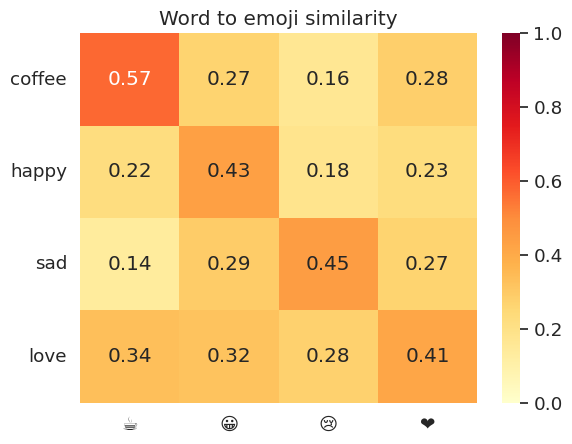

In [ ]:
def plot_similarities(words, emojis):
  message_embeddings = embed(words)
  emoji_names = [emoji_to_name[emoji] for emoji in emojis]
  emoji_embeddings = embed(emoji_names)

  corr = np.inner(message_embeddings, emoji_embeddings)
  print(corr.shape)

  # print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=emojis,
      yticklabels=words,
      annot=True,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_yticklabels(words, rotation=0)
  g.set_title("Word to emoji similarity")

plot_similarities(
    ["coffee", "happy", "sad", "love"],
    ["☕", "😀", "😢", "❤️"])

Използвайки $S$ сега можем и да имплементираме оценката на даден модел, който превръща текст към емоджи:

In [ ]:
word_tokenize = WordPunctTokenizer().tokenize

def eval_single(t: str, model: Callable[[str], str]) -> float:
  emoji_count = 0

  tokens = word_tokenize(t)

  emojified = model(t)
  #print(t, emojified)
  emojified_tokens = word_tokenize(emojified)

  for i in range(len(tokens)):
    emoji_count += tokens[i] != emojified_tokens[i]

  #print("emoji count:", emoji_count)
  sim = 0
  for i in range(len(tokens)):
    #print("similarity between", tokens[i], "and", emojified_tokens[i], "is", word_similarity(tokens[i], emojified_tokens[i]))
    sim += S(tokens[i], emojified_tokens[i])

  #print("total sim", total_similarity)
  return np.sqrt(emoji_count / len(tokens)) * (sim / len(tokens))

def eval(corpus: list[str], model: Callable[[str], str]) -> float:
  score = 0
  for t in corpus:
    score += eval_single(t, model)
  return score / len(corpus)

In [ ]:
print(eval_single("heart", lambda x: "❤️"))
print(eval_single("chicken", lambda x: "❤️"))
print(eval_single("chicken", lambda x: "🐔"))
print(eval_single("hearts", lambda x: "💞"))
print(eval_single("hearts", lambda x: "❤️"))
print(eval_single("police car", lambda x: "police 🚓"))

0.6937847137451172
0.26438799500465393
0.9999998807907104
0.6889781951904297
0.6236447095870972
0.535401489730681


  Като текстови корпус за оценяване на моделите сме избрали "twitter-emoji-prediction" корпусът,
  който съдържа голям публикации от Tweeter. Този корпус, по принцип е направен за предсказване
  на 1 емоджи при даден текст, но смятаме, че е подходящ и за нашата задача, тъй като тренировъчните
  данни все пак са избрани специално за предсказване на емоджита.

In [ ]:
twitter_path = kagglehub.dataset_download("hariharasudhanas/twitter-emoji-prediction")

twitter_ds = pd.read_csv(f"{twitter_path}/Train.csv")

test_ds = twitter_ds.sample(n = 100)
test_ds.head(100)

100%|██████████| 3.50M/3.50M [00:00<00:00, 148MB/s]

Extracting files...


,Unnamed: 0,TEXT,Label
67409,67409,Than you a Monkey! LOLOL #NotaMonkey #TeamNOKi...,3
67138,67138,In need of a little USA trip soon! @ South Bea...,11
46047,46047,Some from personal check more on my website #t...,4
6137,6137,Happy #sandiego #pride ! To be honest I don't ...,3
32385,32385,Merry Christmas ya filthy animals ️..... @ Fre...,9
...,...,...,...
37086,37086,Happy birthday to one of my best friends! Here...,15
41737,41737,You used to call me on my #cell phone ... late...,4
27800,27800,"Drop Curls styled by #Luisa_Rye @ Rye, New York\n",18
33073,33073,Yoooooo!! This new album by the raw_tongue_tyr...,7


In [ ]:
print("Score [Identity model]:", eval(test_ds["TEXT"], lambda x: x))

Score [Identity model]: 0.0


In [ ]:
print("Score [Stem model]: ", eval(test_ds["TEXT"][:100], stem_model))

Score [Stem model]:  0.2931543943825943


In [ ]:
print("Score [Skip-Gram model]: ", eval(test_ds["TEXT"][:100], skip_gram_model))

Score [Skip-Gram model]:  0.41433028015771


In [ ]:
print("Score [Wordnet model]: ", eval(test_ds["TEXT"][:10], wordnet_model))

Score [Wordnet model]:  0.23800421215662118


## Експерименти

In [ ]:
for t in test_ds["TEXT"][:30]:
  print("Sentence:", t)
  print("Stem model:", stem_model(t))
  print("Skip-Gram model:", skip_gram_model(t))
  print("Wordnet model", wordnet_model(t))
  print("----------------------------------------------------")

Sentence: Than you a Monkey! LOLOL #NotaMonkey #TeamNOKids #NoChilsZone #JesustaketheWheel #NoMames…

Stem model: Than you a 🐒 ! LOLOL # NotaMonkey # TeamNOKids # NoChilsZone # JesustaketheWheel # NoMames … 
Skip-Gram model: Than you a 🐒 ! LOLOL # NotaMonkey # TeamNOKids # NoChilsZone # JesustaketheWheel # NoMames …
----------------------------------------------------
Sentence: In need of a little USA trip soon! @ South Beach, Miami

Stem model: In need of a little USA trip 🔜 ! @ 🇰🇷 🏖️ , Miami 
Skip-Gram model: In 🛑 of a 🚯 🇺🇸 trip 🔜 ! @ 🇬🇸 🏖 , ⚾
----------------------------------------------------
Sentence: Some from personal check more on my website #traveldiary #venicebeach #elenakuznetsova @ Los…

Stem model: Some from 🧑 ✔️ more on my website # traveldiary # venicebeach # elenakuznetsova @ Los … 
Skip-Gram model: Some from personal ☑ more on my 🇬🇪 # traveldiary # venicebeach # elenakuznetsova @ 🎅 …
----------------------------------------------------
Sentence: Happy #sandiego #pride

## Бъдещо развитие

Има доста начини, по които можем да развием проекта.

Една посока е, това да разширим дефиницията на задачата, като махнем ограничението да се замества точно 1 дума с 1 емоджи и да позволим на моделите да заместват потенциално повече думи с 1 емоджи или обратното. Например изречение, което съдържа в себе си "police car", може директно да замени двете думи с "🚓".

Другата посока, в която можем да подобрим резултатите е да използваме по-сложни модели. Както казахме, задачата е еквивалентна на машинен превод, особено ако приложим и разширението на условието, споменато в миналия параграф. В този случай, ще получим доста по-добри резултати ако започнем да използваме модели като невронни мрежи от тип Long-Short Term Memory или Transformer, които се използват за машинен превод в съвременните системи.